<a href="https://colab.research.google.com/github/Rishiii5455/Zeotap-Intership-Assignment/blob/main/Riyanshu_Rai_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values in Customers:
 CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
Missing values in Products:
 ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
Missing values in Transactions:
 TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64
Columns in merged_data: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y'],
      dtype='object')
Price column does not exist. Adjusting feature engineering.
Lookalike results saved to 'Riyanshu_Rai_Lookalike.csv'
Price column does not exist. Adjusting feature engineering.


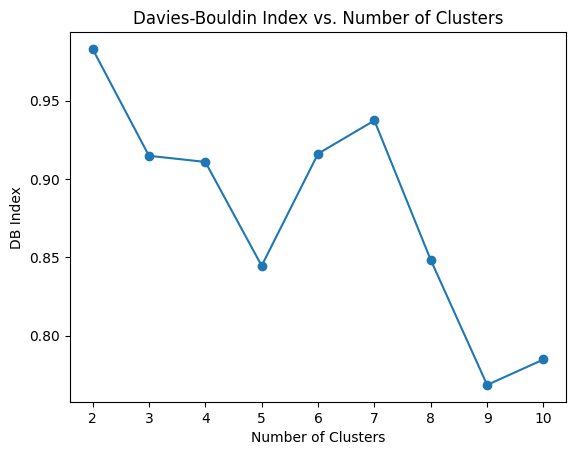

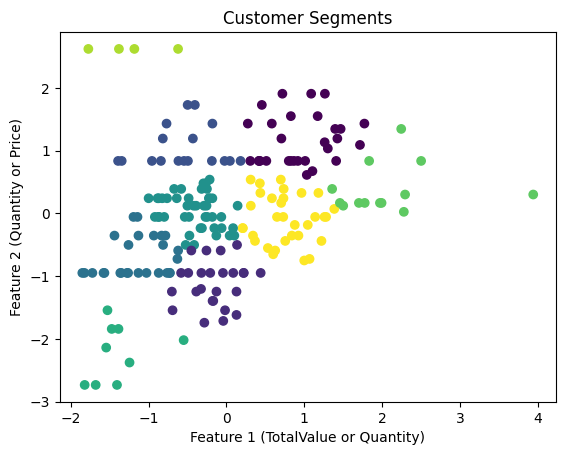

In [8]:
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Check for missing values and duplicates
print("Missing values in Customers:\n", customers.isnull().sum())
print("Missing values in Products:\n", products.isnull().sum())
print("Missing values in Transactions:\n", transactions.isnull().sum())

# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Check the columns in merged_data
print("Columns in merged_data:", merged_data.columns)

# Prepare customer features
if 'Price' in merged_data.columns:
    customer_features = merged_data.groupby('CustomerID').agg({
        'TotalValue': 'sum',
        'Quantity': 'sum',
        'Price': 'mean'  # This line will only work if 'Price' exists
    }).reset_index()
else:
    print("Price column does not exist. Adjusting feature engineering.")
    customer_features = merged_data.groupby('CustomerID').agg({
        'TotalValue': 'sum',
        'Quantity': 'sum'
    }).reset_index()

# Standardize features
scaler = StandardScaler()  # Initialize the scaler
scaled_features = scaler.fit_transform(customer_features.iloc[:, 1:])  # Exclude 'CustomerID'

# Compute cosine similarity
similarities = cosine_similarity(scaled_features)
similarity_df = pd.DataFrame(similarities, index=customer_features['CustomerID'], columns=customer_features['CustomerID'])

# Get top 3 similar customers for the first 20
lookalikes = {}
for cust_id in customer_features['CustomerID'][:20]:
    similar_customers = similarity_df.loc[cust_id].sort_values(ascending=False)[1:4]  # Exclude self
    lookalikes[cust_id] = similar_customers.items()

# Save results
lookalikes_df = pd.DataFrame(lookalikes)
lookalikes_df.to_csv('Riyanshu_Rai_Lookalike.csv', index=False)
print("Lookalike results saved to 'Riyanshu_Rai_Lookalike.csv'")

# Prepare data for clustering
if 'Price' in merged_data.columns:
    clustering_data = merged_data.groupby('CustomerID').agg({
        'TotalValue': 'sum',
        'Quantity': 'mean',
        'Price': 'mean'  # Ensure 'Price' exists in merged_data
    }).reset_index()
else:
    print("Price column does not exist. Adjusting feature engineering.")
    clustering_data = merged_data.groupby('CustomerID').agg({
        'TotalValue': 'sum',
        'Quantity': 'mean'
    }).reset_index()

# Standardize features for clustering
scaled_clustering_data = scaler.fit_transform(clustering_data.iloc[:, 1:])  # Exclude 'CustomerID'

# KMeans clustering
db_scores = []
for k in range(2, 11):  # Test clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_clustering_data)
    db_index = davies_bouldin_score(scaled_clustering_data, kmeans.labels_)
    db_scores.append(db_index)

# Plot DB Index
plt.plot(range(2, 11), db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Final clustering with optimal clusters
optimal_k = db_scores.index(min(db_scores)) + 2
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(scaled_clustering_data)

# Visualize clusters
plt.scatter(scaled_clustering_data[:, 0], scaled_clustering_data[:, 1], c=final_kmeans.labels_, cmap='viridis')
plt.title('Customer Segments')
plt.xlabel('Feature 1 (TotalValue or Quantity)')
plt.ylabel('Feature 2 (Quantity or Price)')
plt.show()
